In [24]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

In [54]:
Images = "Desktop/images_002.tar/images_002/images" #link to dataset of more than 10,000 NIH images
Target_dir = "Dataset/NoFinding"#Target directories for each class to be sent to after filtering, this will change according to 
#which disease is being filtered(Cardiomelagy,Hernia,Nofinding,etc)


In [20]:
df = pd.read_csv("Data_Entry_2017_v2020.csv")#read csv data about NIH dataset
print(df.shape)

(112120, 11)


In [4]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [144]:
df.info()# Contains 11 columns and 112120 Entries
#data types inclued, object, int64,float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 9.4+ MB


In [145]:
df.describe(include='all')#we can see that the PA X-ray view position has the most images, so we will use that during filtering
#we see that Nofinding is the most frequent label

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
count,112120,112120,112120.000000,112120.000000,112120.000000,112120,112120,112120.000000,112120.000000,112120.000000,112120.000000
unique,112120,836,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN
top,00000001_000.png,No Finding,NaN,NaN,NaN,M,PA,NaN,NaN,NaN,NaN
freq,1,60361,NaN,NaN,NaN,63340,67310,NaN,NaN,NaN,NaN
mean,NaN,NaN,8.573751,14346.381743,46.626365,NaN,NaN,2646.078844,2486.438842,0.155649,0.155649
std,NaN,NaN,15.406320,8403.876972,16.602680,NaN,NaN,341.246429,401.268227,0.016174,0.016174
min,NaN,NaN,0.000000,1.000000,0.000000,NaN,NaN,1143.000000,966.000000,0.115000,0.115000
25%,NaN,NaN,0.000000,7310.750000,34.000000,NaN,NaN,2500.000000,2048.000000,0.143000,0.143000
50%,NaN,NaN,3.000000,13993.000000,49.000000,NaN,NaN,2518.000000,2544.000000,0.143000,0.143000
75%,NaN,NaN,10.000000,20673.000000,59.000000,NaN,NaN,2992.000000,2991.000000,0.168000,0.168000


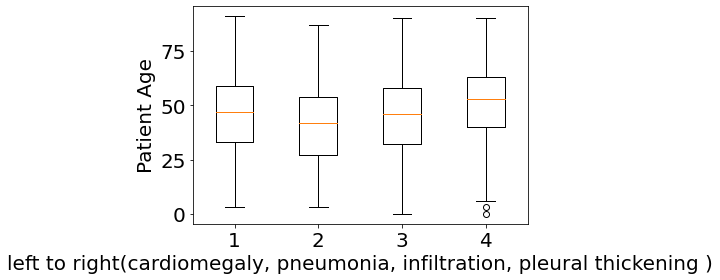

In [143]:
plt.boxplot([df[df['Finding Labels']=='Cardiomegaly']['Patient Age'], 
             df[df['Finding Labels']=='Pneumonia']['Patient Age'], df[df['Finding Labels']=='Infiltration']['Patient Age'], df[df['Finding Labels']=='Pleural_Thickening']['Patient Age']])
plt.xlabel('left to right(cardiomegaly, pneumonia, infiltration, pleural thickening )')

plt.ylabel('Patient Age')
#plt.savefig('.png')
plt.show()
#Below we can see that for Cardiomelagy, Pneumonia, infiltration and pleural thickening the median age of the patients is 
#in or arund age 50, which conforms with the preceding cell result that shows the mean of the patient age column is 46.626365 

<AxesSubplot:ylabel='Patient Gender'>

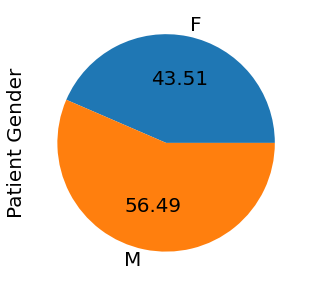

In [148]:
#we see that there are more male patients than they are females, this would seem to suggest that males in middle age are more
#susceptible to lung diseases than their female counterparts
data = df.groupby('Patient Gender')['Patient Gender'].count()
data.plot.pie(autopct='%.2f',figsize=(5,5))

In [5]:
#importing necessary libraries
import os
import shutil

In [55]:
if not os.path.exists(Target_dir):#if path doesn't exits , create the folder
    os.mkdir(Target_dir)
    print("Folder Created")

Folder Created


In [56]:
count = 0
for (i,row) in df.iterrows(): #search through df
    #if statement checks for a particular class, if View Position == PA and Patient Age is greater or equal to 50
    #In this case it is "No Finding", but we searched through for all classes(Cordiomegaly,Mass,Nodule)etc
    if row["Finding Labels"] == "No Finding" and row["View Position"] == "PA" and row["Patient Age"] >= 50:#if condition satisfied
        filename = row["Image Index"]#get file name
        image_path = os.path.join(Images, filename)#link file name with image
        image_copy_path = os.path.join(Target_dir, filename)#link filename with our target directory
        shutil.copy2(image_path,image_copy_path)#send image to target directory
        print("Transferring Image", count)
        count += 1 #increase count
print(count)

Transferring Image 0
Transferring Image 1
Transferring Image 2
Transferring Image 3
Transferring Image 4
Transferring Image 5
Transferring Image 6
Transferring Image 7
Transferring Image 8
Transferring Image 9
Transferring Image 10
Transferring Image 11
Transferring Image 12
Transferring Image 13
Transferring Image 14
Transferring Image 15
Transferring Image 16
Transferring Image 17
Transferring Image 18
Transferring Image 19
Transferring Image 20
Transferring Image 21
Transferring Image 22
Transferring Image 23
Transferring Image 24
Transferring Image 25
Transferring Image 26
Transferring Image 27
Transferring Image 28
Transferring Image 29
Transferring Image 30
Transferring Image 31
Transferring Image 32
Transferring Image 33
Transferring Image 34
Transferring Image 35
Transferring Image 36
Transferring Image 37
Transferring Image 38
Transferring Image 39
Transferring Image 40
Transferring Image 41
Transferring Image 42
Transferring Image 43
Transferring Image 44
Transferring Image 4

KeyboardInterrupt: 

In [2]:

from glob import glob
#reading in All image paths using glob and a dictionary called paths
paths = {}
paths["Covid"] = glob("Dataset/Covid-19/*.png")
paths["Covid"] += glob("Dataset/Covid-19/*.jpeg")
paths["Covid"] += glob("Dataset/Covid-19/*.jpg")

paths["NoFindings"] = glob("Dataset/No_findings/*.png")
paths["NoFindings"] += glob("Dataset/No_findings/*.jpeg")
paths["NoFindings"] += glob("Dataset/No_findings/*.jpg")

paths["Pneumonia"] = glob("Dataset/Pneumonia/*.png")
paths["Pneumonia"] += glob("Dataset/Pneumonia/*.jpeg")
paths["Pneumonia"] += glob("Dataset/Pneumonia/*.jpg")


paths["Cardiomegaly"] = glob("Dataset/Cardiomegaly/*.png")
paths["Atelectasis"] = glob("Dataset/Atelectasis/*.png")
paths["Consolidation"] = glob("Dataset/Consolidation/*.png")
paths["Edema"] = glob("Dataset/Edema/*.png")
paths["Effusion"] = glob("Dataset/Effusion/*.png")
paths["Pleural_Thickening"] = glob("Dataset/Pleural_Thickening/*.png")
paths["Fibrosis"] = glob("Dataset/Fibrosis/*.png")
paths["Infiltration"] = glob("Dataset/Infiltration/*.png")
paths["Mass"] = glob("Dataset/Mass/*.png")
paths["Nodule"] = glob("Dataset/Nodule/*.png")
paths["Hernia"] = glob("Dataset/Hernia/*.png")
paths["Emphysema"] = glob("Dataset/Emphysema/*.png")
paths["Pneumothorax"] = glob("Dataset/Pneumothorax/*.png")



#print(images_path["Covid"])
#print(images_path["NoFindings"])
#print(images_path["Pneumonia"])
#print(images_path["Cardiomegaly"])


images_class = {#Giving all class labels a particular key value representation
    "Covid": 0,
    "Pneumonia": 1,
    "NoFindings": 2,
    "Cardiomegaly": 3,
    "Atelectasis": 4,
    "Consolidation": 5,
    "Edema": 6,
    "Effusion": 7,
    "Pleural_Thickening": 8,
    "Fibrosis": 9,
    "Infiltration": 10,
    "Mass": 11,
    "Nodule": 12,
    "Hernia": 13,
    "Emphysema": 14,
    "Pneumothorax": 15
    
}

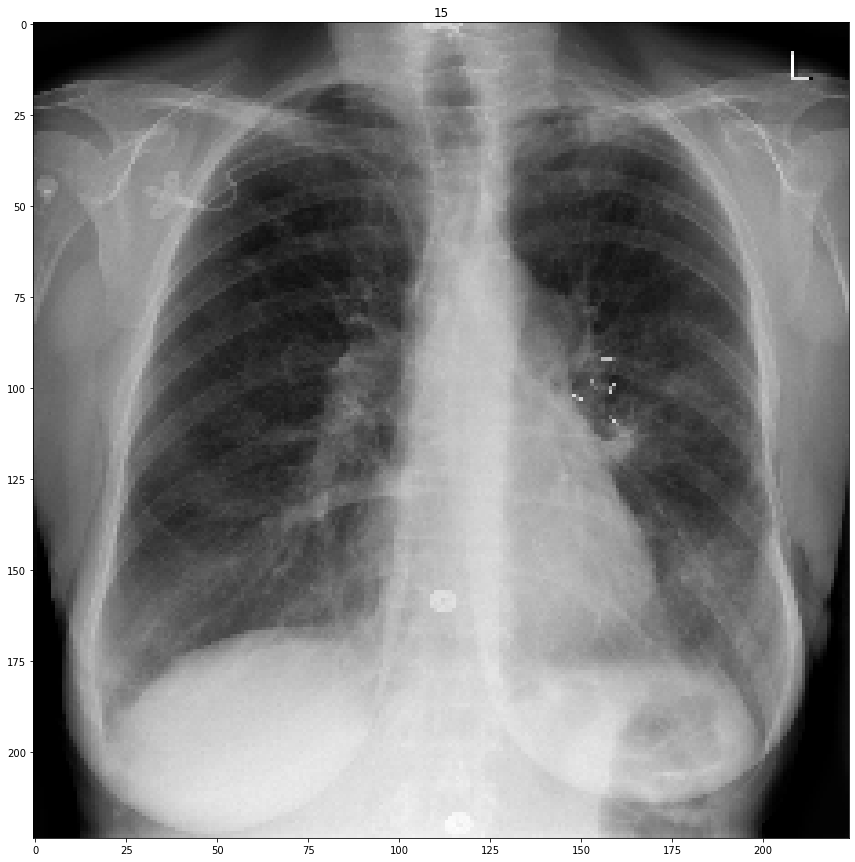

In [3]:

import cv2
import numpy as np
from matplotlib import pyplot as plt
images = []
classes = []

for label in paths:#for class in paths
    for image_path in paths[label]:#for each image path belonging to the class
        image = cv2.imread(image_path)#read image 
        image = cv2.resize(image,(224, 224))#resize image
        images.append(image)
        classes.append(images_class[label])

num = np.random.randint(np.array(images).shape[0]) 
plt.figure(figsize=(15, 15))

plt.title(classes[num])
plt.imshow(images[num])
plt.show()

In [6]:
#analyzing a sample image
sample = images[15]
print("Maximum Pixel Value Of Image: ", sample.max())
print("Minimum Pixel Value Of Image: ", sample.min())
print(f"Image dimension: {sample.shape[0]} x {sample.shape[1]} ")

Maximum Pixel Value Of Image:  225
Minimum Pixel Value Of Image:  1
Image dimension: 224 x 224 


Mean - Pixel Value:  150.17972735969389
Std Deviation Pixel Value:  42.427421807442975


<AxesSubplot:xlabel='Pixel Values', ylabel='Count'>

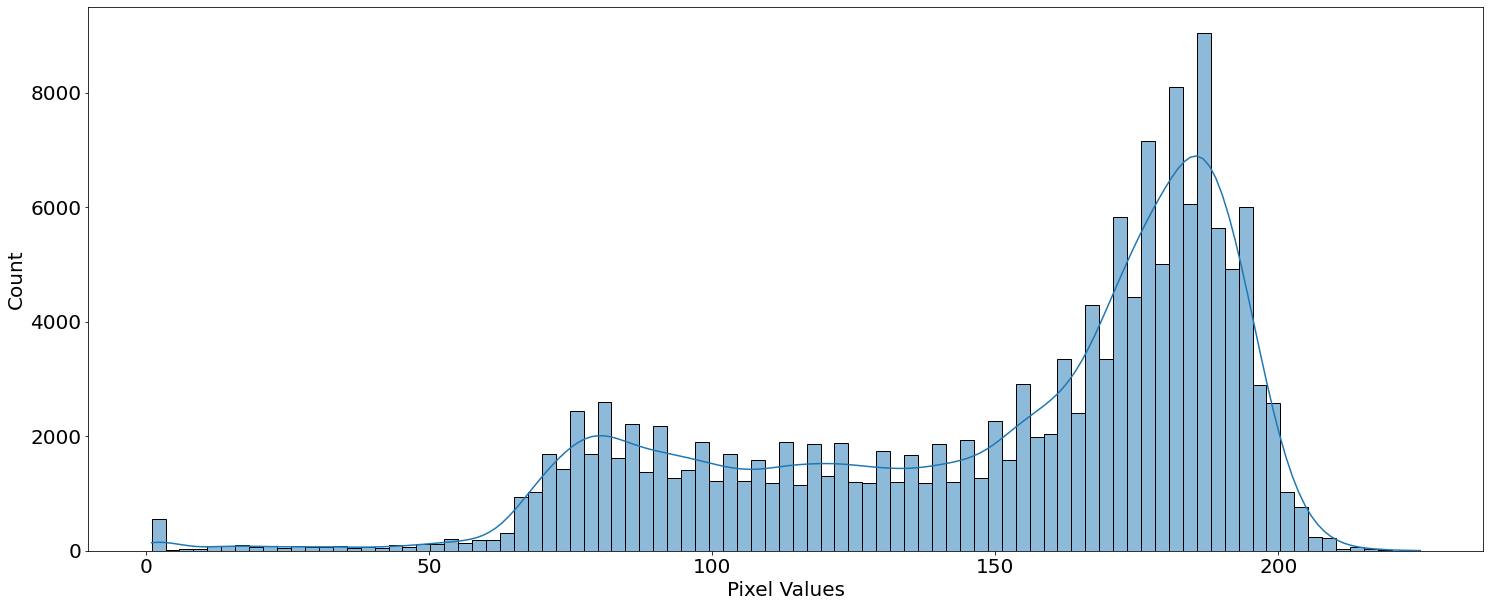

In [7]:
#optional
import seaborn as sns
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(25, 10))
plt.xlabel("Pixel Values")
print("Mean - Pixel Value: ", sample.mean())
print("Std Deviation Pixel Value: ", sample.std())
sns.histplot(sample.ravel(), ax = ax, kde = True)

In [8]:
data = np.array(images)#put images into a numpy array

In [9]:
#run this
import os
#ipaths = list(images_path)
labels = []
#extract the class label
for path in paths:# far each class in paths dictionary
    for image_path in paths[path]: #for all paths of a class
        label = path.split(os.path.sep)[-1]#split and assign to label
        labels.append(label)# append label to labels array       

In [10]:
labels

['Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',
 'Covid',


In [11]:
#run this
data = data/255.0 #normalizing so that intensities range from zero to one

In [12]:
#run this
labels = np.array(labels) #pushing labels into numpy array 


In [13]:
print("X shape is :",data.shape)
print("Y shape is :",labels.shape)

X shape is : (4373, 224, 224, 3)
Y shape is : (4373,)


In [ ]:
import tensorflow#run this

In [14]:
#run this
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from tensorflow.keras.utils import to_categorical
# perform one-hot encoding on the labels
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
labels = to_categorical(labels)

In [15]:
#run this
#binarizing the labels to prepare them for machine learning algorithms
binarizedLabels=[]
for i,label in enumerate(labels):
    if label[0]==1:
        binarizedLabels.append(1)
    else:
        binarizedLabels.append(0)
binarizedLabels=np.array(binarizedLabels)

In [16]:
#run this
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet121, DenseNet169
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.model_selection import cross_validate, KFold
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from xgboost import XGBClassifier

In [17]:
#x = np.array(X)
#y = np.array(Y)
#RUN THIS
# initializing keras pretrained models to flatten and split the data
#from keras.applications.resnet50 import ResNet50
pre_trained_models = {}
pre_trained_models["DenseNet169"] = DenseNet169(include_top=False, input_shape=(224, 224, 3), pooling="avg")
#pre_trained_models["VGG19"] = VGG19(include_top=False, input_shape=(224, 224, 3), pooling="avg")
#pre_trained_models["VGG16"] = VGG16(weights="imagenet",include_top=False, input_shape=(224, 224, 3), pooling="avg")
#pre_trained_models["ResNet50"] = tensorflow.keras.applications.resnet50.ResNet50(include_top=False, input_shape=(224, 224, 3), pooling="avg")

In [18]:
#80% training 20% test
X_train, X_test, Y_train, Y_test = train_test_split(data, binarizedLabels, test_size=0.2, random_state=42)

X_train = pre_trained_models["DenseNet169"].predict(X_train)
X_test = pre_trained_models["DenseNet169"].predict(X_test)
#X_train = pre_trained_models["VGG19"].predict(X_train)
#X_test = pre_trained_models["VGG19"].predict(X_test)
#X_train = pre_trained_models["VGG16"].predict(X_train)
#X_test = pre_trained_models["VGG16"].predict(X_test)
#X_train = pre_trained_models["ResNet50"].predict(X_train)
#X_test = pre_trained_models["ResNet50"].predict(X_test)


28/28 [==============================] - 35s 1s/step


In [19]:
# flattening each image into a vector of features
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print(X_train.shape)
print(X_train.shape)
print(Y_train.shape)

(3498, 1664)
(3498, 1664)
(3498,)


In [20]:
#run this
#Standardizing the dataset because they might behave badly if the individual features do not look like standard normally distributed data
from sklearn import preprocessing, linear_model
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)#Fit to data, then transform it.
X_test = scaler.transform(X_test)#Perform standardization by centering and scaling

In [21]:
#run this, may take a while
#C is inverse of regularization strength and must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(C=1,max_iter=10000).fit(X_train, Y_train)
print("Accuracy:",classifier.score(X_test,Y_test))
print("Predictions :")
print(classifier.predict(X_test))
print("Actual Labels :")
print(Y_test)

Accuracy: 0.8754285714285714
Predictions :
[0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 

In [26]:
#Run this
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error

In [27]:
#Run this
#Going through different model parameters manually may take too much time to find the best, let's create a model to find the optimum variables
from sklearn.svm import SVC
#This model get the cross val score of our training set, Using the various classifiers, as 10 fold cross validation. we get the
#mean of the cv scores for each classifier, if cvscore is better than the best score, we change the optimum variable to a tuple
#of current hyperparameter and cvscore of current hyper parameter
def getBest(classifier, hyperparameters):
    optimum=(0, 0)
    for i in hyperparameters:
        if classifier=='SVM':
            cf = SVC(kernel=i,random_state=1)
        if classifier=='LR':
            cf = LogisticRegression(random_state=1, max_iter=10000, C=i)
        if classifier=='KNN':
            cf = KNeighborsClassifier(n_neighbors=i)
        if classifier=='DT':
            cf = DecisionTreeClassifier(random_state=1, max_depth=i)
        if classifier=='NN':
            cf = MLPClassifier(learning_rate_init=i, random_state=1, max_iter=10000)
        if classifier=='NB':
            cf = BernoulliNB(alpha=i)
        if classifier=='RF':
            cf = RandomForestClassifier(random_state=1, max_depth=i)
        if classifier=='XGB':
            cf = XGBClassifier(learning_rate=0.44, n_estimators=i, random_state=1)

            
        cvscore = cross_val_score(cf, X_train, Y_train, cv=10).mean()
        if cvscore>optimum[1]:
            optimum=(i, cvscore)
    return optimum

In [28]:
#running our model with varying parameters for the classifiers
i, cvscore =getBest('SVM', ['linear','poly','rbf'])
print(f'Optimum SVM (has kernel = {i}) and gives a cv score of: {cvscore}')

i, cvscore =getBest('LR', [0.001, 0.01, 0.1, 1, 10,20,50])
print(f'Optimum Logistic Regression (has C = {i}) and gives a cv score of: {cvscore}')

i, cvscore =getBest('KNN', [i for i in range(1,20)])
print(f'Optimum K-Nearest-Neighbors (has K = {i})  and gives a cv score of: {cvscore}')

i, cvscore =getBest('DT',[i for i in range(1, 20)])
print(f'Optimum Decision Tree (has max_depth = {i})  and gives a cv score of: {cvscore}')

i, cvscore =getBest('NN',[0.0001, 0.001, 0.01, 0.1, 1, 2, 3,4,5,10 ])
print(f'Optimum Neural Network (has learning_rate_init = {i})  and gives a cv score of: {cvscore}')

i, cvscore =getBest('NB',[0.0001, 0.001, 0.01, 0.1, 1, 10, 15, 20])
print(f'Optimum Bernoulli Naive Bayes (has alpha = {i})  and gives a cv score of: {cvscore}')

i, cvscore =getBest('RF',[i for i in range(1,20)])
print(f'Optimum Random Forest (has max_depth = {i})  and gives a cv score of: {cvscore}')

i, cvscore =getBest('XGB',[100, 300, 500, 700])
print(f'Optimum XGB Classifier (has number of estimators = {i})  and gives a cv score of: {cvscore}')

Optimum SVM (has kernel = poly) and gives a cv score of: 0.9273876381498158
Optimum Logistic Regression (has C = 0.001) and gives a cv score of: 0.9273876381498158
Optimum K-Nearest-Neighbors (has K = 10)  and gives a cv score of: 0.9273876381498158
Optimum Decision Tree (has max_depth = 1)  and gives a cv score of: 0.9268162095783874
Optimum Neural Network (has learning_rate_init = 0.0001)  and gives a cv score of: 0.9210994678673762
Optimum Bernoulli Naive Bayes (has alpha = 0.0001)  and gives a cv score of: 0.6846803110929185
Optimum Random Forest (has max_depth = 1)  and gives a cv score of: 0.9273876381498158
Optimum XGB Classifier (has number of estimators = 100)  and gives a cv score of: 0.9265288579615227


In [30]:
#testing what the model suggests with some classifiers
from sklearn.metrics import accuracy_score, classification_report,plot_confusion_matrix

clf = SVC(kernel='rbf',random_state=1)
clf.fit(X_train, Y_train)
yc_pred = clf.predict(X_test)
accuracy_score(Y_test, yc_pred)

0.9165714285714286

In [31]:
XGB_Classifier = XGBClassifier(learning_rate=0.69, n_estimators=100, random_state=0, seed=0, gamma=0)
XGB_Classifier.fit(X_train, Y_train)
Y_pred = XGB_Classifier.predict(X_test)
accuracy_score(Y_test, Y_pred)

0.9188571428571428

In [32]:
NBcf = BernoulliNB(alpha=10)
NBcf.fit(X_train, Y_train)
NBpred = NBcf.predict(X_test)
accuracy_score(Y_test, NBpred)

0.6697142857142857

In [33]:
Rcf = RandomForestClassifier(random_state=1, max_depth=18)
Rcf.fit(X_train, Y_train)
Rpred  = Rcf.predict(X_test)
accuracy_score(Y_test, Rpred)

0.9165714285714286

In [35]:
#Mean Squared Error of models

print(f"Mean squared error of the SVC model ---> {mean_squared_error(Y_test, yc_pred)}")
print(f"Mean squared error of the Naive Bayes model ---> {mean_squared_error(Y_test, NBpred)}")
print(f"Mean squared error of the XGB model ---> {mean_squared_error(Y_test, Y_pred)}")
print(f"Mean squared error of the Random Forest model ---> {mean_squared_error(Y_test, Rpred)}")

Mean squared error of the SVC model ---> 0.08342857142857144
Mean squared error of the Naive Bayes model ---> 0.3302857142857143
Mean squared error of the XGB model ---> 0.08114285714285714
Mean squared error of the Random Forest model ---> 0.08342857142857144


In [36]:
#lets use a classification report to make sure
from sklearn.metrics import accuracy_score, classification_report,plot_confusion_matrix
print(classification_report(Y_test, yc_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       802
           1       0.00      0.00      0.00        73

    accuracy                           0.92       875
   macro avg       0.46      0.50      0.48       875
weighted avg       0.84      0.92      0.88       875



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       802
           1       1.00      0.03      0.05        73

    accuracy                           0.92       875
   macro avg       0.96      0.51      0.51       875
weighted avg       0.93      0.92      0.88       875



In [38]:
print(classification_report(Y_test, NBpred))

              precision    recall  f1-score   support

           0       0.94      0.69      0.79       802
           1       0.12      0.49      0.20        73

    accuracy                           0.67       875
   macro avg       0.53      0.59      0.50       875
weighted avg       0.87      0.67      0.74       875



In [39]:
print(classification_report(Y_test, Rpred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       802
           1       0.00      0.00      0.00        73

    accuracy                           0.92       875
   macro avg       0.46      0.50      0.48       875
weighted avg       0.84      0.92      0.88       875



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
